###Downloading and Importing Libraries

In [1]:
!pip install torch
!pip install transformers
!pip install pandas
!pip install scikit-learn
!pip install sentence-transformers pandas

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

####Imported Library

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import nltk


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Resume.csv', encoding='latin-1')

# Display the DataFrame
df.head(10)

,ID,Profile,Domain
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,33176873,HR DIRECTOR Summary Over 2...,HR
3,27018550,HR SPECIALIST Summary Dedica...,HR
4,17812897,HR MANAGER Skill Highlights ...,HR
5,11592605,HR GENERALIST Summary Dedic...,HR
6,25824789,HR MANAGER Summary HUMAN RES...,HR
7,15375009,HR MANAGER Professional Summa...,HR
8,11847784,HR SPECIALIST Summary Posses...,HR
9,32896934,HR CLERK Summary Translates ...,HR


<ipython-input-5-da54f41f258d>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=domain_counts.index, y=domain_counts.values, palette='viridis')


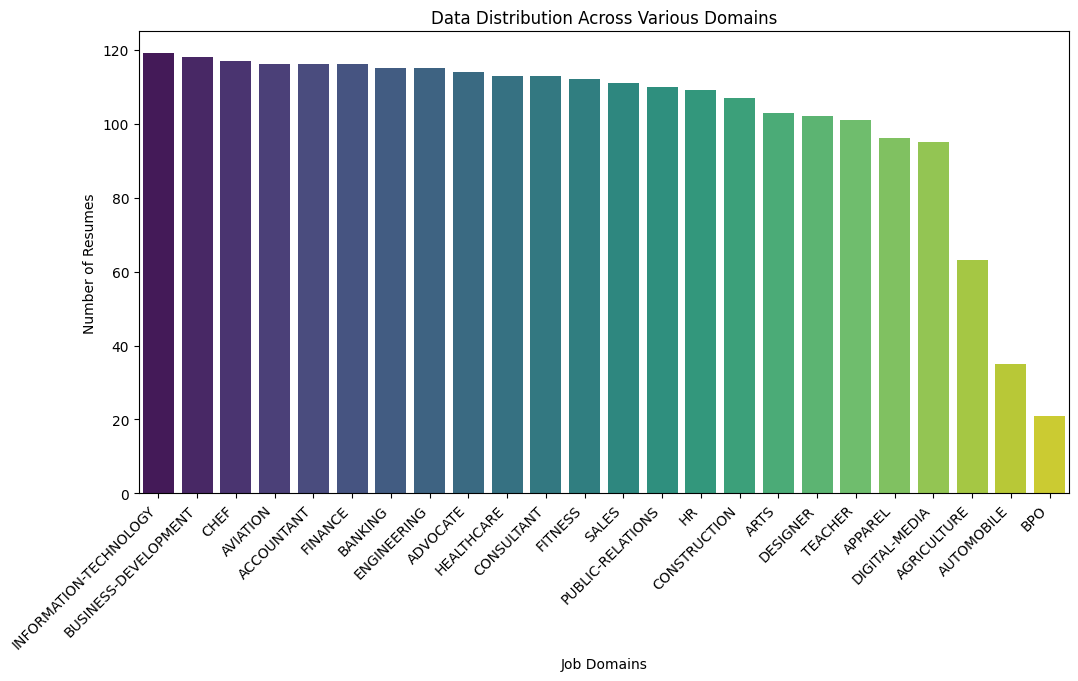

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the occurrences of each domain
domain_counts = df['Domain'].value_counts()

# Plotting the data distribution using a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=domain_counts.index, y=domain_counts.values, palette='viridis')
plt.title('Data Distribution Across Various Domains')
plt.xlabel('Job Domains')
plt.ylabel('Number of Resumes')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()



###Pre-Processing

In [6]:
import re
from nltk.stem import WordNetLemmatizer

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Define a function for text preprocessing
def preprocess_text(text):

    # # Substitute a blank string for all single-letter words
    # text = ' '.join([word for word in text.split() if len(word) > 1])

     # Tokenize text
    word_tokens = word_tokenize(text)

    # Remove HTML tags
    text = re.sub(r"<[^>]*>", " ", text)

    # Remove special characters and punctuation (considering apostrophes)
    text = re.sub(r"[^\w'\s]", " ", text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    text = ' '.join([word for word in word_tokens if word.lower() not in stop_words])

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in word_tokens])

    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text)

    # Trim leading and trailing spaces
    text = text.strip()

    return text

# Apply the preprocessing function to the 'Profile' column in the DataFrame
df['processed_profile'] = df['Profile'].apply(preprocess_text)

# Remove duplicate rows
df = df.drop_duplicates()

# Display the DataFrame with the processed text
print(df[['Profile', 'processed_profile']].head(10))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


                                             Profile  \
0           HR ADMINISTRATOR/MARKETING ASSOCIATE\...   
1           HR SPECIALIST, US HR OPERATIONS      ...   
2           HR DIRECTOR       Summary      Over 2...   
3           HR SPECIALIST       Summary    Dedica...   
4           HR MANAGER         Skill Highlights  ...   
5           HR GENERALIST       Summary     Dedic...   
6           HR MANAGER       Summary    HUMAN RES...   
7           HR MANAGER         Professional Summa...   
8           HR SPECIALIST       Summary    Posses...   
9           HR CLERK       Summary    Translates ...   

                                   processed_profile  
0  HR ADMINISTRATOR MARKETING ASSOCIATE HR ADMINI...  
1  HR SPECIALIST US HR OPERATIONS Summary Versati...  
2  HR DIRECTOR Summary Over 20 year experience in...  
3  HR SPECIALIST Summary Dedicated Driven and Dyn...  
4  HR MANAGER Skill Highlights HR SKILLS HR Depar...  
5  HR GENERALIST Summary Dedicated and focused Ad... 

In [7]:
#Converting strings to lowercase
df['Profile'] = df['Profile'].str.lower()
df['processed_profile'] = df['processed_profile'].str.lower()

In [8]:

# ResumeDataset class
class ResumeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = int(self.labels.iloc[idx])
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        return {'input_ids': encoding['input_ids'].squeeze(), 'attention_mask': encoding['attention_mask'].squeeze(), 'labels': torch.tensor(label)}



####Defining Labels

In [9]:
# function to assign labels based on the job domain
def assign_label(domain):
    # Customizing this function based on domain categories
    if domain == 'HR':
      return 1
    elif domain == 'DESIGNER':
        return 2
    elif domain == 'INFORMATION-TECHNOLOGY':
        return 3
    elif domain == 'TEACHER':
        return 4
    elif domain == 'ADVOCATE':
        return 5
    elif domain == 'BUSINESS-DEVELOPMENT':
        return 6
    elif domain == 'HEALTHCARE':
        return 7
    elif domain == 'FITNESS':
        return 8
    elif domain == 'AGRICULTURE':
        return 9
    elif domain == 'BPO':
        return 10
    elif domain == 'SALES':
        return 11
    elif domain == 'CONSULTANT':
        return 12
    elif domain == 'DIGITAL-MEDIA':
        return 13
    elif domain == 'AUTOMOBILE':
        return 14
    elif domain == 'FINANCE':
        return 15
    elif domain == 'APPAREL':
        return 16
    elif domain == 'ENGINEERING':
        return 17
    elif domain == 'ACCOUNTANT':
        return 18
    elif domain == 'CONSTRUCTION':
        return 19
    elif domain == 'PUBLIC-RELATIONS':
        return 20
    elif domain == 'BANKING':
        return 21
    elif domain == 'ARTS':
        return 22
    elif domain == 'AVIATION':
        return 23
    else:
        return 0  # default label for other domains or cases

# Applying the label assignment function to create a new 'label' column
df['label'] = df['Domain'].apply(assign_label)

print(df.head())


         ID                                            Profile Domain  \
0  16852973           hr administrator/marketing associate\...     HR   
1  22323967           hr specialist, us hr operations      ...     HR   
2  33176873           hr director       summary      over 2...     HR   
3  27018550           hr specialist       summary    dedica...     HR   
4  17812897           hr manager         skill highlights  ...     HR   

                                   processed_profile  label  
0  hr administrator marketing associate hr admini...      1  
1  hr specialist us hr operations summary versati...      1  
2  hr director summary over 20 year experience in...      1  
3  hr specialist summary dedicated driven and dyn...      1  
4  hr manager skill highlights hr skills hr depar...      1  


In [10]:
# Saving the labeled dataset to a new CSV file
labeled_file_path = '/content/drive/MyDrive/Labeled/Labeled_Resume.csv'  # Replace with the desired file path
df.to_csv(labeled_file_path, index=False)

In [11]:
# Splitting the dataset into two sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=3)

In [12]:
# Loading BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=24)  # Assuming binary classification

# Creating datasets and dataloaders
train_dataset = ResumeDataset(train_df['processed_profile'], train_df['label'], tokenizer)
val_dataset = ResumeDataset(val_df['processed_profile'], val_df['label'], tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# training parameters
optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 13

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


###Fine-tunning

In [14]:
# Fine-tuning the BERT model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(epochs):
    model.train()
    total_loss = 0

#Batch Iteration:
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)   #Move to GPU:
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)


        optimizer.zero_grad()     #Zeroing Gradients and Forward Pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss     #Backward Pass and Optimization
        loss.backward()
        optimizer.step()

    total_loss += loss.item()
    average_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {average_loss}')

Epoch 1/13, Loss: 0.04478426839484543
Epoch 2/13, Loss: 0.029524343912718725
Epoch 3/13, Loss: 0.02109810954234639
Epoch 4/13, Loss: 0.01462878653260528
Epoch 5/13, Loss: 0.00797437888677003
Epoch 6/13, Loss: 0.008275796155460546
Epoch 7/13, Loss: 0.01624994492921673
Epoch 8/13, Loss: 0.007633534122685917
Epoch 9/13, Loss: 0.007767201935658689
Epoch 10/13, Loss: 0.008661439184282646
Epoch 11/13, Loss: 0.0014945665588144397
Epoch 12/13, Loss: 0.001033921588639744
Epoch 13/13, Loss: 0.0017167437271993669


In [15]:
# Model Evaluation on the validation set
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in val_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

###Calculating Accuracy

In [16]:
# Calculating Accuracy on the validation set
accuracy = accuracy_score(true_labels, predictions)
print(f'Validation Accuracy: {accuracy}')

Validation Accuracy: 0.7848360655737705


In [17]:
model.save_pretrained('fine_tuned_model')
tokenizer.save_pretrained('fine_tuned_model')

('fine_tuned_model/tokenizer_config.json',
 'fine_tuned_model/special_tokens_map.json',
 'fine_tuned_model/vocab.txt',
 'fine_tuned_model/added_tokens.json')

In [18]:
# To load the saved model later
loaded_model = BertForSequenceClassification.from_pretrained('fine_tuned_model')
loaded_tokenizer = BertTokenizer.from_pretrained('fine_tuned_model')

####Reading Job Description File

In [19]:
!pip install PyMuPDF
import fitz

job_description_pdf_path = "/content/drive/MyDrive/JobFileDescription/Prophaze_Job Description - Tech Interns.pdf"

# Function to extract text from a PDF using PyMuPDF
def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page_num in range(doc.page_count):
        page = doc[page_num]
        text += page.get_text()
    return text

# Extracting text
job_description_text = extract_text_from_pdf(job_description_pdf_path)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 72.6 MB/s eta 0:00:00


In [20]:
nltk.download('stopwords')
nltk.download('punkt')

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

# Example usage
filtered_text = remove_stopwords(job_description_text)
print("Filtered Text:", filtered_text)

Filtered Text: Prophaze : Prophaze cloud native security solution provider . first company around globe launch pure Kubernetes driven SD-WAF . one top four emerging companies space competing WAF OEM 's featured Global WAF Innovation Leader Kuppingercole Analyst report 2022 . Prophaze also one corporate partners international OWASP Community . first real time Automated Cloud Security product company India mission securing applications hacking providing Data Security . awarded innovative product year Data Security Council India 2022 . Prophaze leading Next Generation Web Application Firewall ( WAF ) OEM . featured Global WAF Innovation Leader 2022 competing Global WAF OEM 's . Job description : Tech Interns Various Profiles : DevOps / Laravel / Python Qualification : BSc Computer Science , Engineering relevant field / B.Tech / M-Tech . BCA / MCA Skill Sets DevOps  AWS , EC2 instances , Dockers Kubernetes  Knowledge Terraform , Ansible , REST APIs API Gateway  Automation Jenkins genera

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


####Resume Recommendation

In [21]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util

# Load the fine-tuned BERT model
model_path = '/content/fine_tuned_model'
model = SentenceTransformer(model_path)

# Load the Resume dataset (Assuming it has a 'Resume' column)
resume_df = pd.read_csv('/content/drive/MyDrive/Resume.csv', encoding='latin-1')

def get_top_matching_resumes(job_description, resumes, top_k=10):
    # Encode the job description
    job_description_embedding = model.encode(job_description, convert_to_tensor=True)

    # Encode all resumes
    resume_embeddings = model.encode(resumes['Profile'].tolist(), convert_to_tensor=True)

    # Move tensors to CPU
    job_description_embedding = job_description_embedding.cpu()
    resume_embeddings = resume_embeddings.cpu()

    # Calculate cosine similarities between the job description and all resumes
    similarities = util.pytorch_cos_sim(job_description_embedding, resume_embeddings)[0]

    # Get the indices of the top-k similar resumes
    top_k_indices = similarities.argsort(descending=True)[:top_k]

    # Get the actual top-k resumes
    top_k_resumes = resumes.iloc[top_k_indices]

    return top_k_resumes

# Example usage:
job_description = filtered_text

# Replace 'resume_df' with your actual DataFrame
result_resumes = get_top_matching_resumes(job_description, resume_df)

# Display the result
print(result_resumes)


            ID                                            Profile  \
1319  63989974           IT MANAGER       Summary     IT Produ...   
315   27058381           SYSTEM ADMINISTRATOR             Expe...   
306   89413122           OPERATIONS RESEARCH ANALYST       Sum...   
1314  26341645           SR BUSINESS SYSTEMS ANALYST       Car...   
324   51363762           AMC COMPUTER SPECIALIST AND INTERN   ...   
317   26768723           SUPPORT & NETWORK SERVICES INTERN    ...   
1574  13418452           IT COMPLIANCE AUDITOR       Career Ov...   
311   15791766           PROJECT MANAGER       Summary     Tec...   
318   31243710           IT MANAGER       Summary    Ten years...   
292   20824105           INFORMATION TECHNOLOGY AND AWS ADMIN ...   

                      Domain  
1319              AUTOMOBILE  
315   INFORMATION-TECHNOLOGY  
306   INFORMATION-TECHNOLOGY  
1314              AUTOMOBILE  
324   INFORMATION-TECHNOLOGY  
317   INFORMATION-TECHNOLOGY  
1574                 AP

Comparision with different models(Naive Bayes Model)

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Naive Bayes Model
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['Profile'])
X_val_tfidf = tfidf_vectorizer.transform(val_df['Profile'])

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, train_df['label'])

# Predictions on the validation set
nb_predictions = nb_model.predict(X_val_tfidf)

# Calculating Accuracy for Naive Bayes model
nb_accuracy = accuracy_score(val_df['label'], nb_predictions)
print(f'Naive Bayes Accuracy: {nb_accuracy}')

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, train_df['label'])
rf_predictions = rf_model.predict(X_val_tfidf)
rf_accuracy = accuracy_score(val_df['label'], rf_predictions)
print(f'Random Forest Accuracy: {rf_accuracy}')

# Logistic Regression Classifier
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, train_df['label'])
lr_predictions = lr_model.predict(X_val_tfidf)
lr_accuracy = accuracy_score(val_df['label'], lr_predictions)
print(f'Logistic Regression Accuracy: {lr_accuracy}')

# Linear Support Vector Machine (SVM) Classifier
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_tfidf, train_df['label'])
svm_predictions = svm_model.predict(X_val_tfidf)
svm_accuracy = accuracy_score(val_df['label'], svm_predictions)
print(f'Linear SVM Accuracy: {svm_accuracy}')


Naive Bayes Accuracy: 0.5471311475409836
Random Forest Accuracy: 0.6516393442622951
Logistic Regression Accuracy: 0.6598360655737705
Linear SVM Accuracy: 0.6618852459016393


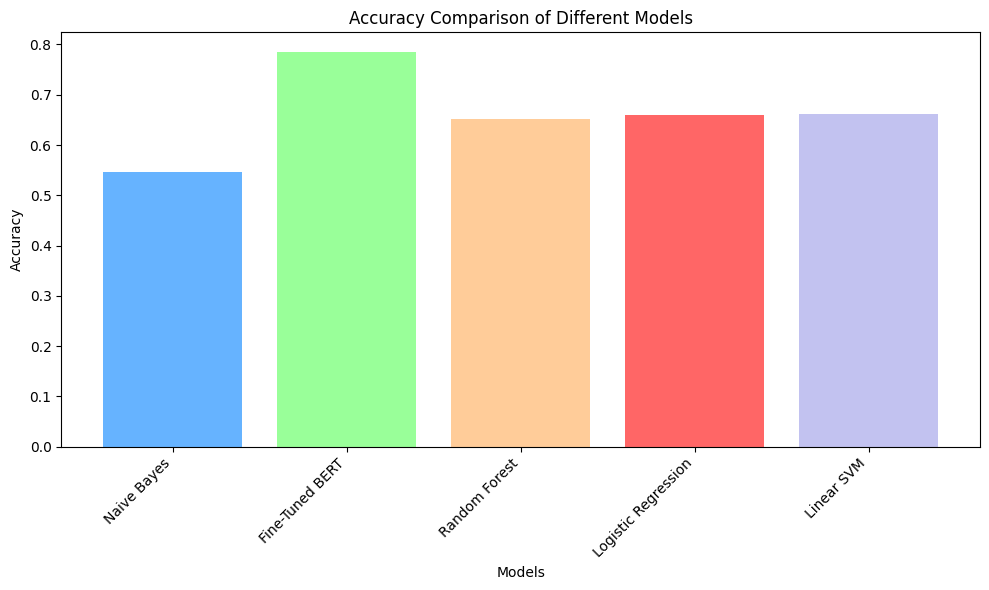

In [23]:
import matplotlib.pyplot as plt

# Accuracy data
accuracy_data = [nb_accuracy, accuracy, rf_accuracy, lr_accuracy, svm_accuracy]
models = ['Naive Bayes', 'Fine-Tuned BERT', 'Random Forest', 'Logistic Regression', 'Linear SVM']

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, accuracy_data, color=['#66b3ff','#99ff99','#ffcc99','#ff6666','#c2c2f0'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


###Feedback Module

In [25]:
!pip install openai
!openai migrate
import openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.2/325.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.5 MB/s eta 0:00:00
Retrieving Grit CLI metadata from https://api.keygen.sh/v1/accounts/custodian-dev/artifacts/marzano-linux-x64
Fetching release URL from: https://api.keygen.sh//v1/accounts/custodian-dev/artifacts/marzano-linux-x64
Fetching release URL from: https://api.keygen.sh//v1/accounts/custodian-dev/artifacts/gouda-linux-x64
Fetching release URL from: https://api.keygen.sh//v1/accounts/custodian-dev/artifacts/cli-linux-x64
Fetching release URL from: https://api.keygen.sh//v1/accounts/custodian-dev/artifacts/workflow_runner-linux-x64
Fetching release URL from: https://api.keygen.sh//v1/accounts/custodian-dev/artifacts/timekeeper-linux-x64



Analyzing Finding files               

In [26]:
# ---------------------------------------------------------------------Feedback System by Compairing similarities scrore-------------------------------------####

#MODULE-1

import pandas as pd
from sentence_transformers import SentenceTransformer, util
import fitz
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Load the fine-tuned BERT model
model_path = '/content/fine_tuned_model'
model = SentenceTransformer(model_path)

# Function to compare similarity between user resume and job description
def generate_feedback(result_resumes, job_description_pdf_path):
    # Extract text from job description
    job_description_text = extract_text_from_pdf(job_description_pdf_path)
    job_description_text = preprocess_text(job_description_text)

    feedback_dict = {}

    for index, row in result_resumes.iterrows():
        # Preprocess user resume
        user_resume_text = preprocess_text(row['Profile'])

        # Encode user resume and job description
        user_resume_embedding = model.encode(user_resume_text, convert_to_tensor=True)
        job_description_embedding = model.encode(job_description_text, convert_to_tensor=True)

        # Calculate cosine similarity
        similarity_score = util.pytorch_cos_sim(user_resume_embedding, job_description_embedding)[0][0].item()

        # Provide feedback based on similarity score
        if similarity_score >= 0.8:
            feedback = "Your resume closely matches the job description."
        elif similarity_score >= 0.6:
            feedback = "There are some similarities between your resume and the job description."
        elif similarity_score >= 0.4:
            feedback = "Your resume has a few similarities with the job description."
        else:
            feedback = "Your resume doesn't seem to align well with the job description."

        # Fetch candidate ID from the DataFrame (assuming it's the first column)
        candidate_id = row.iloc[0]  # Adjust the index as needed based on the actual location of the candidate ID
        feedback_dict[candidate_id] = feedback

    return feedback_dict

# Example usage:
# user_resume_csv_path = result_resumes
job_description_pdf_path = "/content/drive/MyDrive/JobFileDescription/Prophaze_Job Description - Tech Interns.pdf"

# Read user resumes from CSV with 'latin-1' encoding
# user_resume_df = pd.read_csv(user_resume_csv_path, encoding='latin-1')

# Generate feedback for each resume
feedback_dict = generate_feedback(result_resumes, job_description_pdf_path)

# Print feedback for each user
for candidate_id, feedback in feedback_dict.items():
    print(f"Candidate ID: {candidate_id}, Feedback: {feedback}")


Candidate ID: 63989974, Feedback: Your resume closely matches the job description.
Candidate ID: 27058381, Feedback: There are some similarities between your resume and the job description.
Candidate ID: 89413122, Feedback: There are some similarities between your resume and the job description.
Candidate ID: 26341645, Feedback: There are some similarities between your resume and the job description.
Candidate ID: 51363762, Feedback: There are some similarities between your resume and the job description.
Candidate ID: 26768723, Feedback: There are some similarities between your resume and the job description.
Candidate ID: 13418452, Feedback: Your resume has a few similarities with the job description.
Candidate ID: 15791766, Feedback: There are some similarities between your resume and the job description.
Candidate ID: 31243710, Feedback: There are some similarities between your resume and the job description.
Candidate ID: 20824105, Feedback: There are some similarities between you

In [27]:
#MODULE-2

def provide_feedback(job_description, resume):
    # Tokenizing and preprocess the job description
    job_description_tokens = preprocess_text(job_description).split()

    # Tokenizing and preprocess the resume
    resume_tokens = preprocess_text(resume).split()

    # Identifing missing skills in the resume
    missing_skills = set(job_description_tokens) - set(resume_tokens)

    if len(missing_skills) == 0:
        feedback = "Congratulations! Your resume meets the job requirements."
    else:
        feedback = f"Your resume is missing the following skills: {', '.join(missing_skills)}."

    return feedback

for index, row in result_resumes.iterrows():
    resume_text = row['Profile']
    feedback = provide_feedback(job_description, resume_text)
    print(f"Feedback for Resume {index + 1}:\n{feedback}\n")


Feedback for Resume 1320:
Your resume is missing the following skills: description, report, build, Council, Time, Generation, BSc, relevant, 2022, portfolio, querying, Testing, framework, featured, solution, AWS, Jenkins, driven, SD, Knowledge, innovative, Interns, Profiles, technology, Min, Prophaze, launch, solid, Upto, BCA, Data, Flask, unit, general, time, mapping, Various, SIEM, Leader, month, REST, 5000, skill, providing, Global, communication, Stipend, Engineering, understanding, HTML5, 8, mindset, API, Firewall, Source, Great, Job, architecture, front, India, Ansible, Computer, provider, Good, name, also, Laravel, SecOps, ability, Innovation, INR, real, mission, Automation, JavaScript, around, Django, SQL, solving, Gateway, 6, MVC, four, Pipelines, A, PHP, CI, Terraform, Performance, performing, Reliability, Application, Skill, international, competing, M, Web, Familiarity, first, 's, Community, native, debug, B, learn, Practical, Kubernetes, Kuppingercole, hr, Tech, ORM, web, 